### Postmodel Analysis

This notebook will guide the `triage` user through some useful rutines to compare individual models across `model_group_id`'s. This is an interactive process that combines huntches and some general ways to compare 
models. Before starting this process, is important to run `triage`'s _Audition_ component which will filter
`model_group_id`'s using user-defined metrics (see [Audition](https://github.com/dssg/triage/blob/master/src/triage/component/audition/Audition_Tutorial.ipynb) to explore more). 

In [1]:
import pandas as pd
from utils.test_conn import db_engine
from evaluator import get_models_ids, ModelExtractor
from matplotlib import pyplot as plt

/mnt/data/users/ihiguera/triage/triage_env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### 1. Load audited models in a list
Audition will output a dict object with a set of models for each of the defined metrics. We can either read from Audition output, or we can define a list (`audited_models`) to start the post-modeling exploration. We will get each individual `model_id` from the audited `model_groups_id`'s and get the relevant metadata and matrices for each models using the `ModelExtractor` class. 

In [2]:
# List the audited model groups
audited_models = [19,43,55]

# Get models_ids tuples from selected model_group_ids
list_tuple_models = get_models_ids(audited_models)

# Use ModelExtractor object and retrieve model metadata
l_t = [ModelExtractor(i.model_group_id, i.model_id) for i in list_tuple_models]

In [3]:
len(l_t)

9

We can explore each of the model class attributes:

In [4]:
l_t[0].__dict__

{'model_id': 44,
 'model_group_id': 19,
 'model_type': 'sklearn.ensemble.RandomForestClassifier',
 'hyperparameters': {'criterion': 'gini',
  'class_weight': 'balanced',
  'max_features': 'sqrt',
  'n_estimators': 1000,
  'min_samples_leaf': 1,
  'min_samples_split': 50},
 'model_hash': '24b5b54afdfd61cf89b10d02b5c5e31d',
 'train_matrix_uuid': '936d9a0559092efbde15043d36b557a0',
 'pred_matrix_uuid': '8a2f41920a5b27466c278751f7643b50',
 'train_matrix': None,
 'pred_matrix': None,
 'preds': None,
 'feature_importances': None}

Or we can explore all our models:

In [4]:
model_df = pd.DataFrame([model.__dict__ for model in l_t])
model_df.loc[:, ['model_group_id', 'model_id', 'model_type', 'hyperparameters']].sort_values(['model_group_id'])

,model_group_id,model_id,model_type,hyperparameters
0,19,44,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'class_weight': 'balance..."
3,19,86,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'class_weight': 'balance..."
6,19,128,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'class_weight': 'balance..."
1,43,68,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'class_weight': 'balance..."
4,43,110,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'class_weight': 'balance..."
7,43,152,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'class_weight': 'balance..."
2,55,80,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'class_weight': 'balance..."
5,55,122,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'class_weight': 'balance..."
8,55,164,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'class_weight': 'balance..."


Some of the attributes are defined as `None` by default due to memory and efficiency constraints. To load _heavy_ matrices and predictions we have different methods to do so. The `load_features_preds_matrix` and `load_train_matix` methods are helpful options that will retrieve matrices from either AWS S3 or local files (depending on the `path` argument, the function will use the rigth approach). 

In [5]:
l_t[0].load_features_preds_matrix('/mnt/data/users/ihiguera/dirtyduck/triage/output/matrices/')

### 2. Individual model exploration

We can split the model exploration in several steps: 
1. Features
2. Predicted labels distribution


#### 1. Features importances

We can extract individual feature importances from `triage` results schema and indentify the important features for each model. In this `dirtyduck` example, we find that the feature score for importance has a bi-modal behavior, which persists even when removing the features with 0 importance value. 

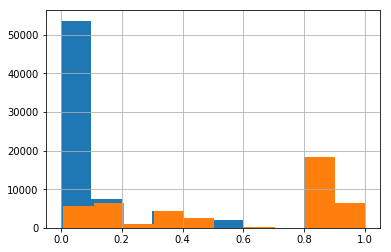

In [25]:
f_importances = l_t[0].feature_importances
f_importances_no_zeros = f_importances[f_importances.feature_value > 0]

l_t[0].feature_importances['feature_value'].hist()
f_importances_no_zeros['feature_value'].hist()

We can also plot the top-10 features by importance

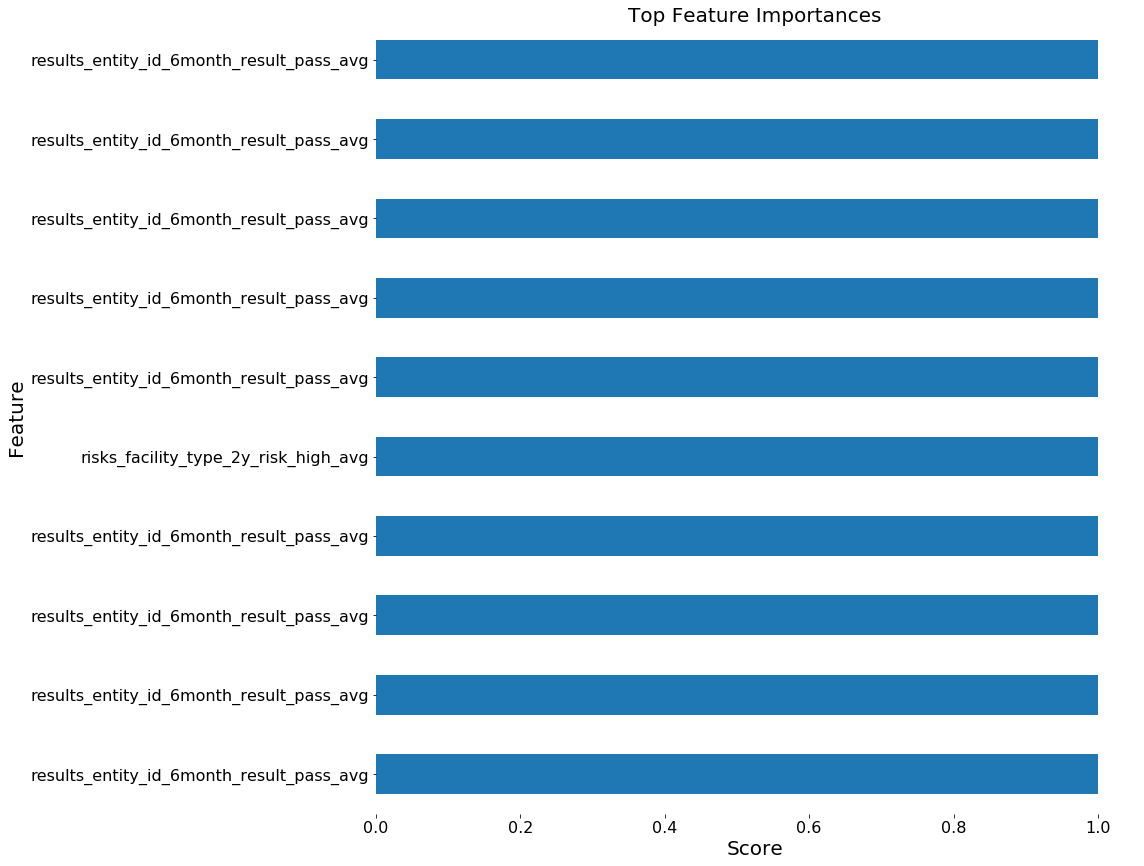

In [26]:
l_t[0].plot_feature_importances(n_features=10)